Experiment to use lora to make a lying model. Here we think of Lora as a probe, as it acts in a very similar way - modifying the residual stream.

Then the hope is it will assist at lie detecting and generalize to unseen dataset

- https://github.dev/JD-P/minihf/blob/b54075c34ef88d9550e37fdf709e78e5a68787c4/lora_tune.py
- https://github.com/jonkrohn/NLP-with-LLMs

In [28]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

plt.style.use("ggplot")

from typing import Optional, List, Dict, Union
from jaxtyping import Float
from torch import Tensor

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path
from einops import rearrange

import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, AutoConfig
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType, LoftQConfig, IA3Config

import datasets
from datasets import Dataset

from loguru import logger

logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")


# # quiet please
torch.set_float32_matmul_precision("medium")
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
# warnings.filterwarnings(
#     "ignore", ".*sampler has shuffling enabled, it is strongly recommended that.*"
# )
# warnings.filterwarnings("ignore", ".*has been removed as a dependency of.*")


In [29]:
# load my code
%load_ext autoreload
%autoreload 2

import lightning.pytorch as pl
from src.datasets.dm import DeceptionDataModule
from src.models.pl_lora_ft import AtapterFinetuner

from src.config import ExtractConfig
from src.prompts.prompt_loading import load_preproc_dataset, load_preproc_datasets
from src.models.load import load_model
from src.helpers.torch import clear_mem
from src.models.phi.model_phi import PhiForCausalLMWHS


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parameters


In [30]:
# params
max_epochs = 3
device = "cuda:0"

cfg = ExtractConfig(
    max_examples=(300, 100),
    
    # model="wassname/phi-1_5-w_hidden_states",
    # batch_size=3,

    # model="wassname/phi-2-w_hidden_states",
    model="Walmart-the-bag/phi-2-uncensored",
    batch_size=1,
    prompt_format="phi",
)


## Load model

In [31]:
model, tokenizer = load_model(
    cfg.model,
    device=device,
    model_class=PhiForCausalLMWHS,
)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# TODO I would like to only have biases, but for now lets just try a very small intervention on the last parts of a layer...
peft_config = LoraConfig(
    target_modules=[
        "out_proj",
        "mlp.fc2",
    ],  # only the layers that go directly to the residual
    # bias="lora_only",
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=4,
    lora_alpha=4,
    lora_dropout=0.0,
)


# peft_config = IA3Config(
#     task_type=TaskType.SEQ_CLS, target_modules=[ "out_proj",
#         "mlp.fc2",], feedforward_modules=["out_proj", "mlp.fc2",]
# )
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()


trainable params: 2,293,760 || all params: 2,781,977,600 || trainable%: 0.08245069981871889


## Load datasets

In [ ]:
N = sum(cfg.max_examples)
ds_tokens = load_preproc_datasets(cfg.datasets,
                      tokenizer,
        N=N,
        seed=cfg.seed,
        num_shots=cfg.num_shots,
        max_length=cfg.max_length,
        prompt_format=cfg.prompt_format,
)
ds_tokens
# datasets2 = []
# for ds_name in cfg.datasets:
#     N = sum(cfg.max_examples)
#     ds_tokens1 = load_preproc_dataset(
#         ds_name,
#         tokenizer,
#         N=N,
#         seed=cfg.seed,
#         num_shots=cfg.num_shots,
#         max_length=cfg.max_length,
#         prompt_format=cfg.prompt_format,
#     ).with_format("torch")
#     datasets2.append(ds_tokens1)
# ds_tokens = datasets.interleave_datasets(datasets2)
# ds_tokens


2023-12-22 14:45:25.293 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:350 - setting tokenizer chat template to phi
2023-12-22T14:45:25.293941+0800 INFO setting tokenizer chat template to phi
2023-12-22 14:45:25.379 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:381 - median token length: 443.0 for amazon_polarity. max_length=776
2023-12-22T14:45:25.379831+0800 INFO median token length: 443.0 for amazon_polarity. max_length=776
2023-12-22 14:45:25.380 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:385 - truncation rate: 0.00% on amazon_polarity
2023-12-22T14:45:25.380933+0800 INFO truncation rate: 0.00% on amazon_polarity
2023-12-22 14:45:25.388 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:394 - num_rows (after filtering out truncated rows) 604=>604
2023-12-22T14:45:25.388884+0800 INFO num_rows (after filtering out truncated rows) 604=>604
choice_ids: 100%|██████████| 604/604 [00:00<00:00, 8772.63 examples/s]
2023-12-22 14:45:27

Dataset({
    features: ['ds_string', 'example_i', 'answer', 'messages', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'question', 'input_ids', 'attention_mask', 'truncated', 'length', 'prompt_truncated', 'choice_ids'],
    num_rows: 402
})

In [ ]:
datasets2 = []
for ds_name in cfg.datasets_oos:
    N = sum(cfg.max_examples)//2
    ds_tokens1 = load_preproc_dataset(
        ds_name,
        tokenizer,
        N=N,
        seed=cfg.seed,
        num_shots=cfg.num_shots,
        max_length=cfg.max_length,
        prompt_format=cfg.prompt_format,
    ).with_format("torch")
    datasets2.append(ds_tokens1)
ds_tokens2 = datasets.concatenate_datasets(datasets2)
ds_tokens2


choice_ids: 100%|██████████| 602/602 [00:00<00:00, 8292.65 examples/s]
2023-12-22 14:45:29.344 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:381 - median token length: 290.0 for glue:qnli. max_length=776
2023-12-22T14:45:29.344744+0800 INFO median token length: 290.0 for glue:qnli. max_length=776
2023-12-22 14:45:29.345 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:385 - truncation rate: 0.00% on glue:qnli
2023-12-22T14:45:29.345483+0800 INFO truncation rate: 0.00% on glue:qnli
Filter: 100%|██████████| 602/602 [00:00<00:00, 2579.10 examples/s]
2023-12-22 14:45:29.802 | INFO     | src.prompts.prompt_loading:load_preproc_dataset:394 - num_rows (after filtering out truncated rows) 602=>602
2023-12-22T14:45:29.802968+0800 INFO num_rows (after filtering out truncated rows) 602=>602


Dataset({
    features: ['ds_string', 'example_i', 'answer', 'messages', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'question', 'input_ids', 'attention_mask', 'truncated', 'length', 'prompt_truncated', 'choice_ids'],
    num_rows: 200
})

## Train

In [ ]:
dm = DeceptionDataModule(ds_tokens, batch_size=cfg.batch_size)
dm


In [ ]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()


In [ ]:
b = next(iter(dl_train))
print(b.keys(), b["input_ids"].shape)
c_in = b["input_ids"].shape[1]
c_in


dict_keys(['ds_string', 'example_i', 'answer', 'messages', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'question', 'input_ids', 'attention_mask', 'truncated', 'length', 'prompt_truncated', 'choice_ids']) torch.Size([1, 776])


776

In [ ]:
net = AtapterFinetuner(
    model, tokenizer, lr=5e-3, weight_decay=1e-5, total_steps=len(dl_train) * max_epochs
)

print(c_in)
# net.model.enable_adapters()


776


In [ ]:
# # debug
# with torch.no_grad():
#     o = net.training_step(b, None)
# o


In [ ]:
# # debug
# with torch.no_grad():
#     o = net.predict_step(b, None)
# o.keys()


In [ ]:
# we want to init lightning early, so it inits accelerate
trainer1 = pl.Trainer(
    # precision="16-true", # leads to inf loss?
    # precision="16-mixed", # works
    # precision="bf16-mixed",
    gradient_clip_val=20,
    # accelerator="auto",
    devices="1",
    accelerator="gpu",
    # devices=[0],
    accumulate_grad_batches=4,
    max_epochs=max_epochs,
    log_every_n_steps=1,
    enable_model_summary=False,
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [ ]:
trainer1.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val);


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 2: 100%|██████████| 201/201 [02:46<00:00,  1.21it/s, v_num=4]        

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 201/201 [02:48<00:00,  1.19it/s, v_num=4]


In [ ]:
checkpoint_path = Path(trainer1.log_dir)/'final'
model.save_pretrained(checkpoint_path)
checkpoint_path


PosixPath('/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/notebooks/lightning_logs/version_4/final')

,train/loss_step,val/loss_step
step,,
0,10.510482,0.084306
1,11.369137,0.286171
2,3.745987,0.602362
3,13.137023,0.734049
4,9.514082,0.203751
...,...,...
295,NaN,-0.003399
296,NaN,0.066307
297,NaN,1.440213


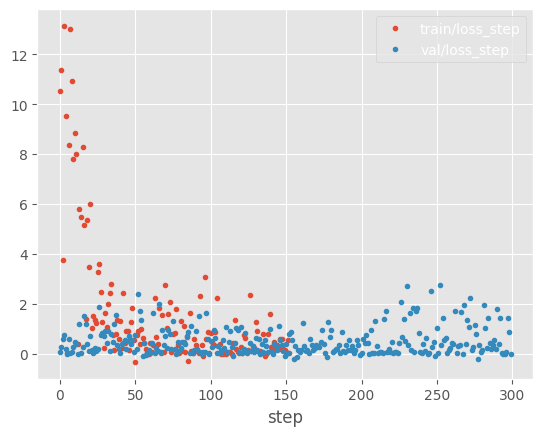

In [ ]:
from src.helpers.lightning import read_metrics_csv

_, df_hist = read_metrics_csv(trainer1.logger.experiment.metrics_file_path)
df_hist[['train/loss_step', 'val/loss_step']].plot(style='.')
df_hist


## Generate


In [ ]:
model, tokenizer = model, tokenizer = load_model(
    cfg.model,
    device=device,
    adaptor_path=checkpoint_path,
    dtype=torch.float16, # bfloat can't be pickled
)
clear_mem()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.11it/s]


In [ ]:
# get a row
bi = 4
inputs = ds_tokens.with_format("torch")[bi]

from src.eval.gen import gen


In [ ]:
with model.disable_adapter():
    gen(model, inputs, tokenizer)

gen(model, inputs, tokenizer)


/media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.venv/lib/python3.11/site-packages/transformers/generation/utils.py:1421: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


# Test

In [ ]:
from src.eval.helpers import test_intervention_quality2
from src.eval.labels import ds2label_model_obey, ds2label_model_truth


In [ ]:
dm = DeceptionDataModule(ds_tokens, batch_size=cfg.batch_size * 2)
dl_train2 = dm.train_dataloader()
dl_val2 = dm.val_dataloader()
dl_test2 = dm.test_dataloader()


In [ ]:
dl_oos2 = DataLoader(
    ds_tokens2, batch_size=cfg.batch_size * 2, drop_last=False, shuffle=False
)
len(ds_tokens2)


200

In [ ]:
# rs = trainer1.test(
#     net,
#     dataloaders=[
#         # dl_train2, dl_val2,
#         dl_test2,
#         dl_oos2,
#     ],
# )
# rs = rename(rs, ["train", "val", "test", "oos"])
# rs[0]


# Predict

Here we want to see if we can do a probe on the hidden states to see if it's lying...


### Collect

- see how acc each was for instructions vs truth
- see how a linear probe trained on the diff can do for truth, vs baseline

In [35]:
model, tokenizer = model, tokenizer = load_model(
    cfg.model,
    device=device,
    adaptor_path=checkpoint_path,
    dtype=torch.float16, # bfloat can't be pickled
    model_class=PhiForCausalLMWHS,
)
clear_mem()


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
Loading checkpoint shards: 100%|██████████| 3/3 [00:02<00:00,  1.04it/s]


In [37]:
from src.eval.collect import manual_collect2
ds_out, f = manual_collect2(dl_oos2, model, dataset_name="oos")


2023-12-22 15:33:28.679 | INFO     | src.eval.collect:manual_collect2:56 - creating dataset /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_oos_7ef57ab75b6cc834
2023-12-22T15:33:28.679316+0800 INFO creating dataset /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_oos_7ef57ab75b6cc834
2023-12-22T15:33:28.679316+0800 INFO creating dataset /media/wassname/SGIronWolf/projects5/elk/sgd_probes_are_lie_detectors/.ds/ds_oos_7ef57ab75b6cc834
collecting hidden states:   2%|▏         | 2/100 [00:09<07:14,  4.43s/it]

### Eval

In [ ]:
# TODO limit it to ones where it knows
for label_name, label_fn in dict(label_model_truth=ds2label_model_truth, label_model_obey=ds2label_model_obey).items():
    # fit probe
    print('='*80)
    print('making intervention with', label_name, 'hidden states')
    test_intervention_quality2(ds_out, label_fn, tokenizer)


### Check dataset of outputs

In [ ]:
from src.eval.ds import qc_ds, ds2df, qc_dsdf


In [ ]:
df = ds2df(ds_out)
df


In [ ]:
# TODO one for base, one for adapter
# TODO is acc and lie_acc the same... so it's ignoring the examples and system instrucitons... maybe I need a instruction tuned one?
qc_ds(ds_out)


In [ ]:
print('acc by dataset and template name')
df1 = ds2df(ds_out)
df_b = df1.rename(columns=lambda x: x.replace('_base', '')).copy()
df_a = df1.rename(columns=lambda x: x.replace('_adapt', '')).copy()
for ds_string, ddf in df_b.groupby(['ds_string', 'template_name']):
    print(ds_string)
    qc_dsdf(ddf)
    



In [ ]:
print('acc by dataset and sys_instr_name')
df = ds2df(ds_out.with_format('numpy')).rename(columns=lambda x: x.replace('_base', ''))
df['ans'] = df['binary_ans'] >0.5
df['label_instructed'] = df['label_true'] ^ df['instructed_to_lie']
for ds_string, ddf in df.groupby(['ds_string','sys_instr_name']):
    print(ds_string)
    qc_dsdf(ddf)
